🟣 PROBLEM STATEMENT: As a deep learning consultant you have been hired by an hospital and you have been given a task to automate the process of detecting and classfying chest disease and reduce the cost and time of detection. The team has collected extensive X-ray chest data and they apprroached you to develop a model that could detect and classify the diseases in less than 1 minute. You have been provided with 133 images that belong to 4 classes:

📁 Healthy
📁 COVID-19
📁 Bacterial Pneumonia
📁 Viral Pneumonia

🟠 Import Libraries

In [1]:
!pip install opencv-python

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [3]:
# Loading the data
train_directory = 'D:\Detecting and Classifying Chest Disease\Dataset'

In [4]:
os.listdir(train_directory)

['0', '1', '2', '3']

In [5]:
# Using image generator to generate tensor images and normalize them and use 20% 0f data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [6]:
# Generate batches of 40 images

train_generator = image_generator.flow_from_directory(batch_size = 40, directory = train_directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [7]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory = train_directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


In [8]:
# Generate batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [9]:
train_images.shape

(40, 256, 256, 3)

In [10]:
train_labels.shape

(40, 4)

In [11]:
train_labels

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]],

In [12]:
# label translator
label_names = {0: 'Covid-19', 1: 'Normal', 2:'Viral Pneumonia', 3:'Bacterial Pneumonia'}

🔴 Data Visualizzation

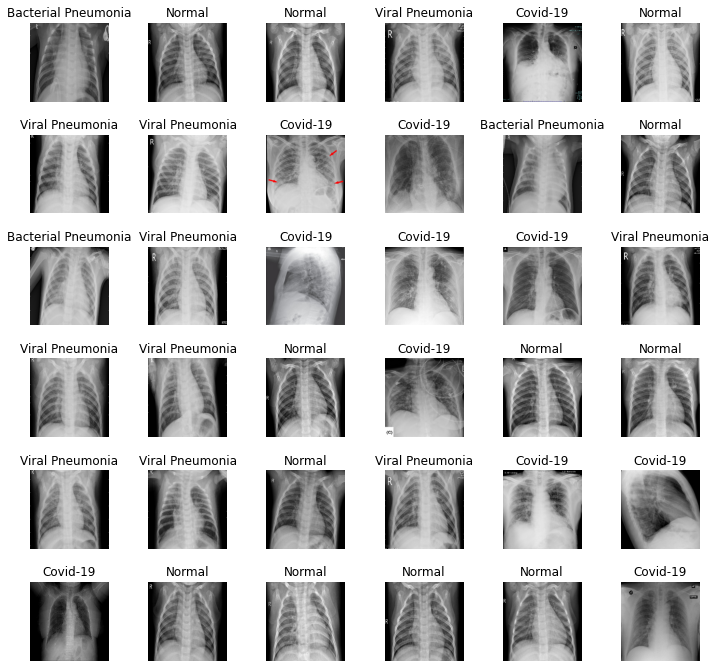

In [13]:
Length = 6
Width = 6

fig, axes = plt.subplots(Length,  Width, figsize = (12,12))
axes = axes.ravel() # ravel is used to flatten the axes

for i in np.arange(0, Length * Width):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')
    
plt.subplots_adjust(wspace = 0.5)

🟢 Importing models with pretrained weights for performing Transerfer learning

In [14]:
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape = (256, 256, 3)))

In [15]:
# Freezing layers in the model
for layer in basemodel.layers[:-10]:
    layers.trainable = False

🔵 Build and train deep neural network model

In [29]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel)
headmodel = Flatten(name = 'flatten')(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(64, activation = 'relu')(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(16, activation = 'relu')(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

In [30]:
model = Model(inputs = basemodel.input, outputs = headmodel)

In [31]:
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(learning_rate = 1e-4), metrics = ['accuracy'])

In [32]:
# Early stopping to exit training if validation loss is not decreasing after certain number of epochs
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 12)

In [33]:
# Saving the model that has lover validation loss
checkpointer = ModelCheckpoint(filepath = 'weights.hdf5', verbose = 1, save_best_only = True)

In [34]:
train_generator = image_generator.flow_from_directory(batch_size = 8, directory = train_directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'training')
val_generator = image_generator.flow_from_directory(batch_size = 8, directory = train_directory, shuffle = True, target_size = (256, 256), class_mode = 'categorical', subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [35]:
history = model.fit(train_generator, epochs = 15, validation_data = val_generator, callbacks = [checkpointer, earlystopping])

Epoch 1/15
54/54 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8692
Epoch 1: val_loss improved from inf to 3.82419, saving model to weights.hdf5
54/54 [==============================] - 141s 2s/step - loss: 0.4131 - accuracy: 0.8692 - val_loss: 3.8242 - val_accuracy: 0.2500
Epoch 2/15
54/54 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9463
Epoch 2: val_loss did not improve from 3.82419
54/54 [==============================] - 128s 2s/step - loss: 0.1441 - accuracy: 0.9463 - val_loss: 15.4543 - val_accuracy: 0.2596
Epoch 3/15
54/54 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9860
Epoch 3: val_loss improved from 3.82419 to 2.02377, saving model to weights.hdf5
54/54 [==============================] - 130s 2s/step - loss: 0.0503 - accuracy: 0.9860 - val_loss: 2.0238 - val_accuracy: 0.3846
Epoch 4/15
54/54 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9813
Epoch 4: val_loss did not im

🟢 Evaluating the trained deep learning model

In [36]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'Training accuracy and loss')

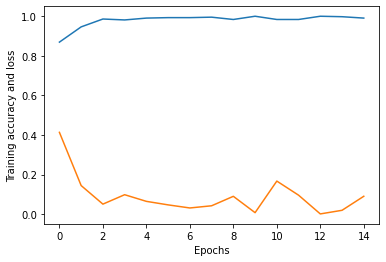

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training accuracy and loss')                         

Text(0, 0.5, 'validation loss')

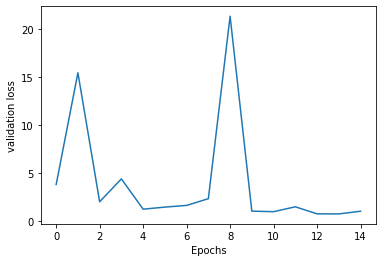

In [38]:
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('validation loss')      

Text(0, 0.5, 'validation accuracy')

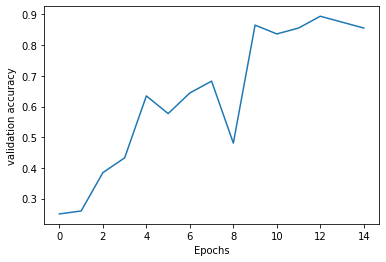

In [39]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('validation accuracy')   

In [40]:
test_directory = 'D:\Detecting and Classifying Chest Disease\Test'

In [41]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 4, 
                                              directory = test_directory, 
                                              shuffle = True,
                                              target_size = (256, 256), 
                                              class_mode = 'categorical') 

Found 40 images belonging to 4 classes.


In [42]:
evaluation = model.evaluate(test_generator, 
                                    steps = test_generator.n // 4, 
                                    verbose = 1)
print("Accuracy Test : {}".format(evaluation[1]))                                    

10/10 [==============================] - 3s 277ms/step - loss: 2.1377 - accuracy: 0.7750
Accuracy Test : 0.7749999761581421


In [43]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
    for item in os.listdir(os.path.join(test_directory, str(i))):
        img = cv2.imread(os.path.join(test_directory, str(i), item))
        img = cv2.resize(img,(256,256))
        image.append(img)
        img = img/255
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 96ms/step


In [44]:
score = accuracy_score(original, prediction)
print("Test Accuracy: {}".format(score))

Test Accuracy: 0.775


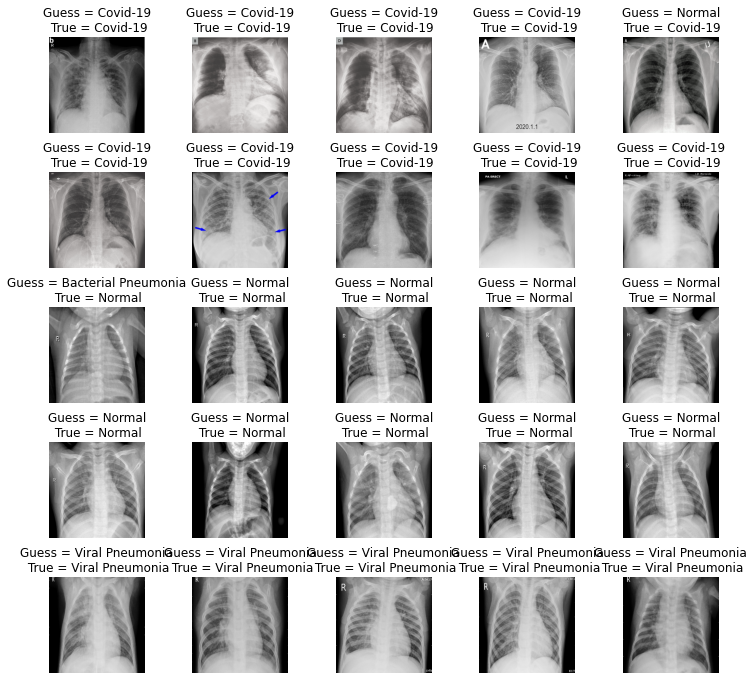

In [46]:
Length = 5
Width = 5
fig, axes = plt.subplots(Length, Width, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, Length*Width):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess = {}\n True = {}'.format(str(label_names[prediction[i]]),
                                                      str(label_names[original[i]])))
    axes[i].axis('off')
    
plt.subplots_adjust(wspace = 0.5)

In [47]:
print(classification_report(np.array(original), np.array(prediction)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.64      0.90      0.75        10
           2       1.00      0.50      0.67        10
           3       0.67      0.80      0.73        10

    accuracy                           0.78        40
   macro avg       0.83      0.77      0.77        40
weighted avg       0.83      0.78      0.77        40



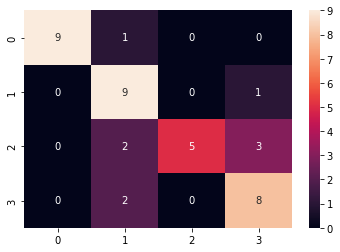

In [48]:
cm = confusion_matrix(np.array(original), np.array(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel = ('Predicted')
ax.set_ylabel = ('Original')
ax.set_title = ('Confusion_matrix')